In [19]:
import cudf
import cupy as cp
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Columns
columns_to_use = [
    'ball', 'bowl', 'bat', 'inns', 'line', 'length', 'shot',
    'score', 'out', 'cur_bat_runs', 'cur_bat_bf', 'cur_bowl_runs',
    'cur_bowl_wkts', 'inns_runs', 'inns_wkts', 'inns_rr',
    'wagonX', 'wagonY', 'wagonZone', 'bowl_style', 'bat_hand'
]
dtypes = {
    'ball': 'float32', 'inns': 'int8', 'score': 'int8', 'out': 'bool',
    'cur_bat_runs': 'int16', 'cur_bat_bf': 'int16', 'cur_bowl_runs': 'int16',
    'cur_bowl_wkts': 'int8', 'inns_runs': 'int16', 'inns_wkts': 'int8',
    'inns_rr': 'float32', 'wagonX': 'float32', 'wagonY': 'float32'
}

# Load
df = cudf.read_csv('/kaggle/input/odi-data/odi_bbb-25.csv', usecols=columns_to_use, dtype=dtypes)

# Impute
df['line'] = df['line'].fillna('UNKNOWN')
df['length'] = df['length'].fillna('UNKNOWN')
df['shot'] = df['shot'].fillna('NO_SHOT')
df['inns_rr'] = df['inns_rr'].fillna(df['inns_rr'].mean())
df['wagonX'] = df['wagonX'].fillna(0)
df['wagonY'] = df['wagonY'].fillna(0)
df['bowl_style'] = df['bowl_style'].fillna('UNKNOWN')
df['bat_hand'] = df['bat_hand'].fillna('UNKNOWN')

# Encode
df_pd = df.to_pandas()
df_encoded = pd.get_dummies(df_pd, columns=['line', 'length', 'bowl_style', 'bat_hand'], drop_first=True)
df_encoded = cudf.from_pandas(df_encoded)

# Copy columns
df_encoded['score'] = df['score']
df_encoded['out'] = df['out']

# Feature engineering
df_encoded['bowl_recent_runs'] = df.groupby('bowl')['score'].rolling(30, min_periods=1).mean().shift(1).reset_index(level=0, drop=True).fillna(0)
df_encoded['bat_strike'] = df.groupby('bat')['score'].rolling(10, min_periods=1).mean().shift(1).reset_index(level=0, drop=True).fillna(0) * 100
df_encoded['pressure'] = (df['inns_rr'] - df['inns_runs'] / df['ball'].replace(0, np.nan)).fillna(0)
df_encoded['bowl_recent_wkts'] = df.groupby('bowl')['out'].rolling(30, min_periods=1).sum().shift(1).reset_index(level=0, drop=True).fillna(0)
df_encoded['bat_dismissal_risk'] = df.groupby('bat')['out'].rolling(10, min_periods=1).mean().shift(1).reset_index(level=0, drop=True).fillna(0)
df_encoded['is_spin'] = df['bowl_style'].str.lower().str.contains('spin').astype(int)
df_encoded['is_boundary'] = (df_encoded['score'] >= 4).astype(int)
df_encoded['bat_boundary_rate'] = df_encoded.groupby('bat')['is_boundary'].rolling(10, min_periods=1).mean().shift(1).reset_index(level=0, drop=True).fillna(0)
df_encoded = df_encoded.drop(['is_boundary', 'score'], axis=1)
df_encoded['bowl_run_variance'] = df.groupby('bowl')['score'].rolling(30, min_periods=1).var().shift(1).reset_index(level=0, drop=True).fillna(0)
df_encoded['wagon_distance'] = cudf.Series(cp.sqrt(df['wagonX']**2 + df['wagonY']**2)).fillna(0)
df_encoded['bat_form'] = df.groupby('bat')['score'].rolling(20, min_periods=1).sum().shift(1).reset_index(level=0, drop=True).fillna(0)

# Features
features = [col for col in df_encoded.columns if col.startswith('line_') or col.startswith('length_')] + [
    'bowl_recent_runs', 'bat_strike', 'inns_rr', 'cur_bat_runs',
    'cur_bowl_wkts', 'bowl_recent_wkts', 'bat_dismissal_risk', 'is_spin',
    'bat_boundary_rate', 'bowl_run_variance', 'wagon_distance', 'bat_form'
]

# Check NaNs
print("NaNs in imputed features:")
print(df_encoded[features].isnull().sum())

NaNs in imputed features:
line_ON_THE_STUMPS               0
line_OUTSIDE_OFFSTUMP            0
line_UNKNOWN                     0
line_WIDE_DOWN_LEG               0
line_WIDE_OUTSIDE_OFFSTUMP       0
length_FULL_TOSS                 0
length_GOOD_LENGTH               0
length_SHORT                     0
length_SHORT_OF_A_GOOD_LENGTH    0
length_UNKNOWN                   0
length_YORKER                    0
bowl_recent_runs                 0
bat_strike                       0
inns_rr                          0
cur_bat_runs                     0
cur_bowl_wkts                    0
bowl_recent_wkts                 0
bat_dismissal_risk               0
is_spin                          0
bat_boundary_rate                0
bowl_run_variance                0
wagon_distance                   0
bat_form                         0
dtype: int64


In [16]:
# Initial model
X_temp = df_encoded[features].to_cupy()
y_temp = df_encoded['out'].to_cupy()
model_temp = XGBClassifier(max_depth=3, n_estimators=50, random_state=42, device="cuda")
model_temp.fit(X_temp, y_temp)
feature_imp = pd.Series(model_temp.feature_importances_, index=features).sort_values()
print("Initial feature importance (imputed):")
print(feature_imp)

# Drop low-importance
low_imp = feature_imp[feature_imp < 0.01].index
features = [f for f in features if f not in low_imp]
print("Refined imputed features:", features)

Initial feature importance (imputed):
is_spin                          0.000000
bat_strike                       0.000448
line_OUTSIDE_OFFSTUMP            0.000460
length_FULL_TOSS                 0.001031
length_UNKNOWN                   0.001427
line_UNKNOWN                     0.002908
length_SHORT_OF_A_GOOD_LENGTH    0.002942
bowl_run_variance                0.003210
length_YORKER                    0.004532
line_WIDE_DOWN_LEG               0.005481
bat_boundary_rate                0.007448
bat_form                         0.007526
bat_dismissal_risk               0.010319
cur_bat_runs                     0.014004
line_WIDE_OUTSIDE_OFFSTUMP       0.015654
inns_rr                          0.025009
bowl_recent_runs                 0.028290
wagon_distance                   0.033685
length_GOOD_LENGTH               0.056502
length_SHORT                     0.076121
line_ON_THE_STUMPS               0.137895
bowl_recent_wkts                 0.180434
cur_bowl_wkts                    0.384

Imputed Wickets Model:
              precision    recall  f1-score   support

       False       0.99      0.93      0.96    265458
        True       0.20      0.58      0.30      7513

    accuracy                           0.92    272971
   macro avg       0.59      0.76      0.63    272971
weighted avg       0.97      0.92      0.94    272971



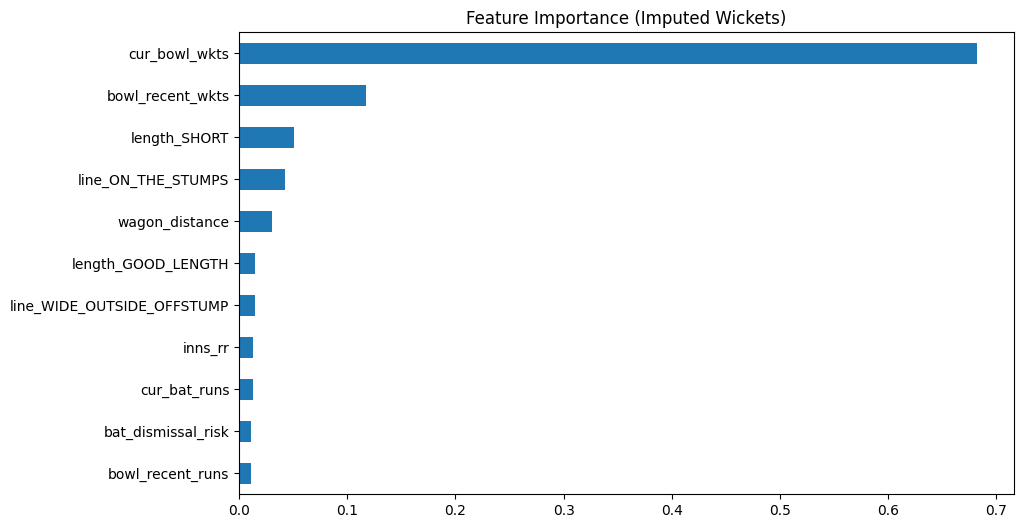

In [13]:
from sklearn.model_selection import train_test_split

X = df_encoded[features].to_cupy()
y = df_encoded['out'].to_cupy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale_pos_weight = (y == 0).sum() / (y == 1).sum() / 2
model_wickets = XGBClassifier(
    scale_pos_weight=scale_pos_weight, max_depth=5, n_estimators=200,
    learning_rate=0.1, min_child_weight=5, random_state=42, device="cuda"
)
model_wickets.fit(X_train, y_train)

# Threshold tuning
y_scores = cp.asnumpy(model_wickets.predict_proba(X_test)[:, 1])
y_test_np = cp.asnumpy(y_test)
precisions, recalls, thresholds = precision_recall_curve(y_test_np, y_scores)
threshold = thresholds[np.argmax(precisions >= 0.20)] if np.any(precisions >= 0.20) else 0.5
y_pred = (y_scores >= threshold).astype(int)
print("Imputed Wickets Model:")
print(classification_report(y_test_np, y_pred))

# Save model
model_wickets.save_model('/kaggle/working/wickets_imputed.json')

plt.figure(figsize=(10, 6))
pd.Series(model_wickets.feature_importances_, index=features).sort_values().plot(kind='barh')
plt.title('Feature Importance (Imputed Wickets)')
plt.show()

In [21]:
df_encoded['score'] = df['score']
X = df_encoded[features].to_cupy()
y = df_encoded['score'].to_cupy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_runs = XGBClassifier(max_depth=5, n_estimators=100, random_state=42, device="cuda")
model_runs.fit(X_train, y_train)
y_pred = cp.asnumpy(model_runs.predict(X_test))
y_test_np = cp.asnumpy(y_test)
print("Imputed Runs Model:")
print(classification_report(y_test_np, y_pred))

model_runs.save_model('/kaggle/working/runs_imputed.json')

Imputed Runs Model:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.68      0.93      0.79    142668
           1       0.62      0.48      0.54     89788
           2       0.58      0.01      0.01     14404
           3       0.72      0.01      0.02      1829
           4       0.67      0.27      0.38     20170
           5       0.00      0.00      0.00       337
           6       0.63      0.13      0.21      3755
           7       0.00      0.00      0.00        20

    accuracy                           0.67    272971
   macro avg       0.49      0.23      0.24    272971
weighted avg       0.65      0.67      0.62    272971



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
df_encoded['shot'] = df['shot']
le_shot = LabelEncoder()
# Filter first, then encode
df_shots = df_encoded[df_encoded['shot'] != 'NO_SHOT'].copy()
df_shots['shot_encoded'] = le_shot.fit_transform(df_shots['shot'].to_pandas())

# Verify classes
print("Unique shot classes:", le_shot.classes_)
print("Number of shot classes:", len(le_shot.classes_))

X = df_shots[features].to_cupy()
y = df_shots['shot_encoded'].to_cupy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class consistency
print("Unique classes in y_train:", cp.unique(y_train).get())
print("Unique classes in y_test:", cp.unique(y_test).get())

model_shots = XGBClassifier(max_depth=5, n_estimators=100, random_state=42, device="cuda")
model_shots.fit(X_train, y_train)
y_pred = cp.asnumpy(model_shots.predict(X_test))
y_test_np = cp.asnumpy(y_test)
print("Imputed Shots Model:")
print(classification_report(y_test_np, y_pred, target_names=le_shot.classes_))

model_shots.save_model('/kaggle/working/shots_imputed.json')

Unique shot classes: ['BACK_DEFENCE' 'COVER_DRIVE' 'CUT_SHOT' 'CUT_SHOT_ON_BACK_FOOT'
 'CUT_SHOT_ON_FRONT_FOOT' 'DAB' 'DEFENDED' 'FLICK' 'FORWARD_DEFENCE'
 'HOOK' 'LATE_CUT' 'LEFT_ALONE' 'LEG_GLANCE' 'OFF_SIDE_DRIVE_ON_BACK_FOOT'
 'OFF_SIDE_DRIVE_ON_FRONT_FOOT' 'ON_DRIVE' 'ON_SIDE_DRIVE_ON_BACK_FOOT'
 'ON_SIDE_DRIVE_ON_FRONT_FOOT' 'PADDED_AWAY' 'PADDLE_AWAY' 'PADDLE_SWEEP'
 'PULL' 'PULL_HOOK_ON_BACK_FOOT' 'PULL_HOOK_ON_FRONT_FOOT' 'PUSH'
 'PUSH_SHOT' 'RAMP' 'REVERSE_PULL' 'REVERSE_SCOOP' 'REVERSE_SWEEP'
 'SLOG_SHOT' 'SLOG_SWEEP' 'SQUARE_DRIVE' 'STEERED' 'STRAIGHT_DRIVE'
 'SWEEP' 'SWEEP_SHOT' 'UPPER_CUT' 'VERTICAL_FORWARD_ATTACK']
Number of shot classes: 39
Unique classes in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Unique classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
Imputed Shots Model:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                BACK_DEFENCE       0.20      0.01      0.02      8280
                 COVER_DRIVE       0.45      0.31      0.37     11943
                    CUT_SHOT       0.38      0.32      0.35      7974
       CUT_SHOT_ON_BACK_FOOT       0.29      0.31      0.30      8300
      CUT_SHOT_ON_FRONT_FOOT       0.00      0.00      0.00       885
                         DAB       1.00      0.00      0.00       770
                    DEFENDED       0.44      0.66      0.53     21301
                       FLICK       0.39      0.49      0.44     16574
             FORWARD_DEFENCE       0.34      0.68      0.45     19961
                        HOOK       0.00      0.00      0.00       248
                    LATE_CUT       0.00      0.00      0.00        64
                  LEFT_ALONE       0.48      0.78      0.60      5850
                  LEG_GLANCE       0.31      0.46      0.37     24457
 OFF_SIDE_DRIVE_ON_

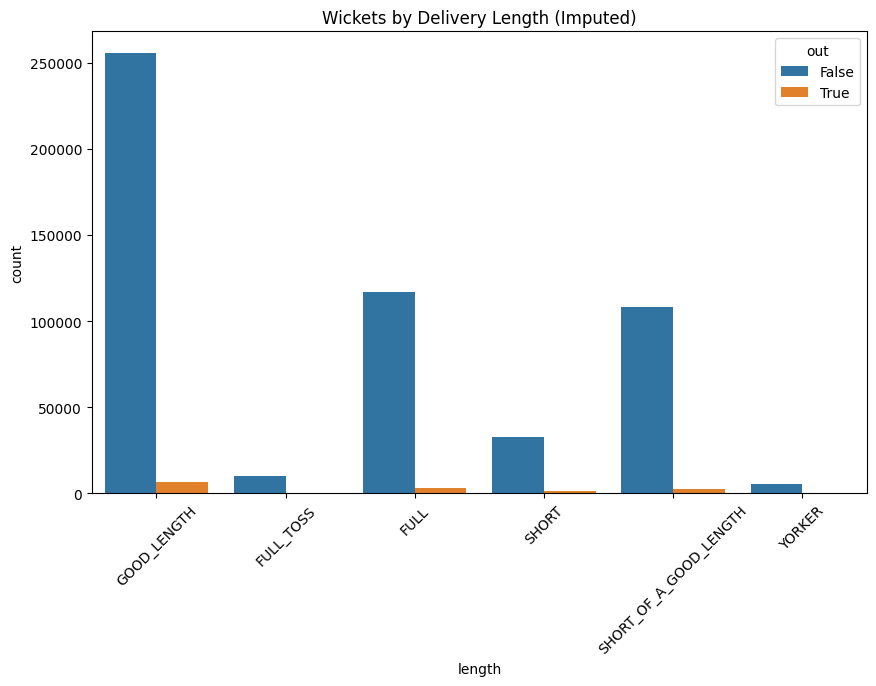

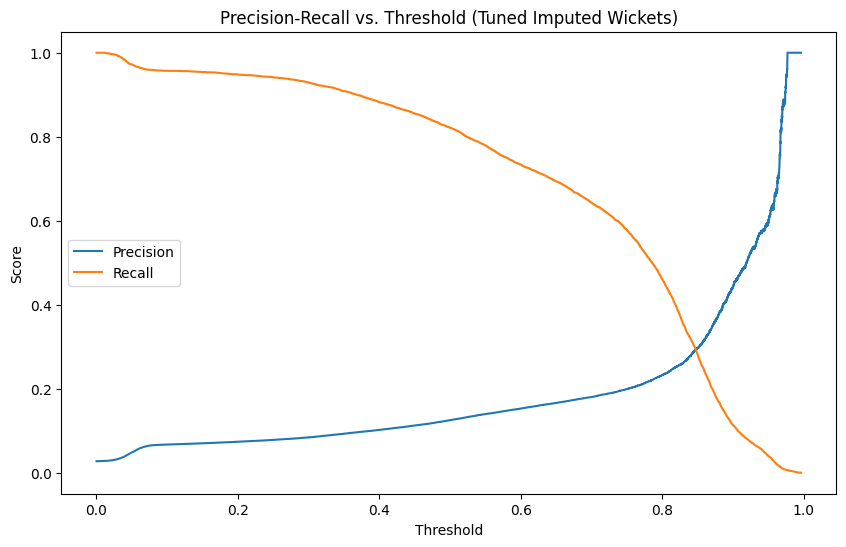

In [23]:
df_viz = df[df['length'] != 'UNKNOWN'].to_pandas()
plt.figure(figsize=(10, 6))
sns.countplot(x='length', hue='out', data=df_viz)
plt.title('Wickets by Delivery Length (Imputed)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.show()